# Madrid Distric Geometries

In this notebook we will try to igure out how to manipulate the district geographical data provided by the Madrid city council so that we can apply it to the city simulation.

We will be using geopandas to read the data, which uses the well know library shapely to interpret the data.

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

Read the data from the .shp file into a pandas dataframe, in which one column will be the distric geometries.

In [106]:
df = gpd.read_file("../data/madrid_districts/madrid_districts.shp")
df = df.rename(columns={
    "NOMBRE": "name",
    "CODDISTRIT": "district_code",
    "SHAPE_area": "area_m2",
    "SHAPE_len": "perimeter_m",
    "geometry": "geometry",
    })
df["district_code"] = df["district_code"].astype("int")
df = df.set_index("district_code", drop=True).sort_index()
df.head()

,name,area_m2,perimeter_m,geometry
district_code,,,,
1,Centro,5.231267e+06,10304.545144,"POLYGON ((441184.740 4473200.754, 441181.200 4..."
2,Arganzuela,6.466406e+06,12834.885747,"POLYGON ((440272.872 4472969.544, 440350.271 4..."
3,Retiro,5.465317e+06,9523.926778,"POLYGON ((443652.112 4473312.571, 443560.700 4..."
4,Salamanca,5.387252e+06,10862.998823,"POLYGON ((444075.165 4476611.812, 444057.794 4..."
5,Chamartín,9.170135e+06,13401.482255,"POLYGON ((442907.033 4481552.856, 442901.023 4..."


We can easily extract the point coordinates from the geometry data, which represent filled polygons with the are of each district.

In [107]:
df["coords_m"] = df["geometry"].apply(lambda x: np.array(x.exterior.coords))
df.head()

,name,area_m2,perimeter_m,geometry,coords_m
district_code,,,,,
1,Centro,5.231267e+06,10304.545144,"POLYGON ((441184.740 4473200.754, 441181.200 4...","[[441184.7400000002, 4473200.753799999], [4411..."
2,Arganzuela,6.466406e+06,12834.885747,"POLYGON ((440272.872 4472969.544, 440350.271 4...","[[440272.87210000027, 4472969.543500001], [440..."
3,Retiro,5.465317e+06,9523.926778,"POLYGON ((443652.112 4473312.571, 443560.700 4...","[[443652.11209999956, 4473312.570900001], [443..."
4,Salamanca,5.387252e+06,10862.998823,"POLYGON ((444075.165 4476611.812, 444057.794 4...","[[444075.16500000004, 4476611.8122000005], [44..."
5,Chamartín,9.170135e+06,13401.482255,"POLYGON ((442907.033 4481552.856, 442901.023 4...","[[442907.0332000004, 4481552.8561], [442901.02..."


We need to transform this data into out own coordinate system. Since we do not know the exact interpretation of the coordinate system in the geometry file, we will make an educated guess and put the Puerta del Sol at the Centroid of the "Centro" district. If you look at Google Maps and search "Centro de Madrid", this is not a bad guess at all.

The unit is clearly meters, which we will change to km as well.

In [109]:
center = np.array(df.loc[1]["geometry"].centroid.coords)
df["coords_km"] = df["coords_m"].apply(lambda x: (x-center)/1e3)
df["geometry"] = df["coords_km"].apply(lambda x: Polygon(x))

We can now go back to the original format and save the shape file.

In [113]:
df = df[["name", "area_m2", "perimeter_m", "geometry"]]
df.head()

,name,area_m2,perimeter_m,geometry
district_code,,,,
1,Centro,5.231267e+06,10304.545144,"POLYGON ((1.01936 -1.11526, 1.01582 -1.13181, ..."
2,Arganzuela,6.466406e+06,12834.885747,"POLYGON ((0.10749 -1.34647, 0.18489 -1.36202, ..."
3,Retiro,5.465317e+06,9523.926778,"POLYGON ((3.48673 -1.00344, 3.39532 -1.23226, ..."
4,Salamanca,5.387252e+06,10862.998823,"POLYGON ((3.90978 2.29580, 3.89241 2.15264, 3...."
5,Chamartín,9.170135e+06,13401.482255,"POLYGON ((2.74165 7.23685, 2.73564 7.17986, 2...."


In [114]:
df.to_file("../data/madrid_districts_processed.shp")

We can also test some functions to help us in the simulator. Mainly, we need something to generate a point inside a given district geometry.

In [117]:
def get_random_point_in_polygon(polygon):
     min_x, min_y, max_x, max_y = polygon.bounds
     while True:
         point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
         if polygon.contains(point):
             return point

Let's see if it works properly by plotting a bunch of points.

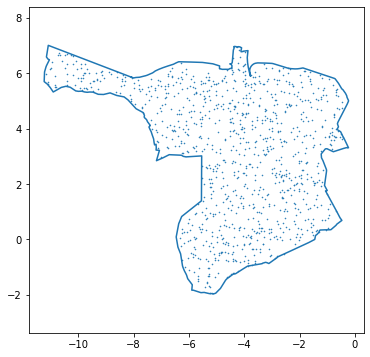

In [219]:
poly = df.loc[8]["geometry"]
poly_coords = np.array(poly.exterior.coords)

points_coords = np.array([np.array(get_random_point_in_polygon(poly).coords).flatten() for _ in range(1000)]).T

fig = plt.figure(1, figsize=(6, 6))
ax = fig.subplots(1)

ax.axis("equal")
ax.plot(poly_coords[:, 0], poly_coords[:, 1])
ax.scatter(points_coords[0], points_coords[1], s=0.3)

We should streamline the process for the city simulator.

In [224]:
def random_loc_in_distric(district_code):
    polygon = df.loc[district_code]["geometry"]
    point = get_random_point_in_polygon(polygon)
    x, y = np.array(point.coords).flatten().tolist()
    return (x, y, district_code)

In [225]:
random_loc_in_distric(1)

(1.4972899832117366, -3.2626905020638253, 1)